In [1]:
import pandas as pd

import sqlite3
import pandas as pd

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


# Create db connection.
cnx = sqlite3.connect('data/database.sqlite')





seasons = ['2015/2016']
leagues_id = [21518]


In [2]:
## Cleaning names of teams

import stringdist

# Normalize names 
def normalize_team_names(y):
    teams = []
    for t in list(y):
        tt = t.lower().split()
        rem = []
        cont=0
        #print(tt)
        for el in tt:
            cont +=1
            if el in ['athletico','atletico','athlético','atlético','atl','ath','athletic']: 
                if cont < len(tt):
                    tt[cont]='atl'+tt[cont]
            if el in ['manchester','man','sporting','sp','deportivo','la','de','real','fc','cf','ud','las','cd','balompié','rc','de','athletico','atletico','athlético','atlético','atl','ath','athletic']:
                rem.append(el)
            
                #print(tt)
        if rem != []:
            for r in rem:
                tt.remove(r)
        
        if len(tt)>1:
            if len(tt[0])>len(tt[1]):
                t = tt[0]
            else:
                t = tt[1]
        else:
            t=tt[0]
        #print(t)  
        teams.append(t)
    return teams

#Change name x for the most similar name in the teams_normalized list.
def func(x,teams_normalized):
    dist =0
    distmin=10
    xt = x.lower().split()
    rem = []
    cont=0
    for el in xt:
        cont +=1
        if el in ['athletico','atletico','athlético','atlético','atl','ath','athletic']:
            if cont < len(xt):
                xt[cont]='atl'+xt[cont]
        if el in ['manchester','man','sporting','sp','deportivo','la','de','real','fc','cf','ud','las','cd','balompié','rc','de','athletico','atletico','athlético','atlético','atl','ath','athletic']:
            rem.append(el)
    if rem != []:
        for r in rem:
                xt.remove(r)
                


    if len(xt)>1:
        if len(xt[0])>len(xt[1]):
            x = xt[0]
        else:
            x = xt[1]
    else:
        x=xt[0]

    
    for t in list(teams_normalized):
        dist = stringdist.levenshtein(x, t)
        #print(t)
        if dist < distmin:
            #print('................')
            #print(x)
            #print(t)
            #print(dist)
            #print('................')
            distmin = dist
            team =t
    return team



def convert_to(df,type_to_convert, all_categorical = False,columns = 'None'):
 
    if all_categorical == True:
        categoric_types = df.select_dtypes(include=['object','category']).columns
        if categoric_types.empty:
            print('No object types in the dataframe to be converted')
            return df
        else:
            if 'labels' in categoric_types:
                categoric_types.remove('labels')
            df[categoric_types] = df[categoric_types].astype('category')
            columns = categoric_types
        
    else:
        df[columns] = df[columns].astype('category')
        
        
    if type_to_convert == 'labelling':
        for column in columns:
            df[column] = df[column].cat.codes
    elif type_to_convert == 'onehot':
        for column in columns:
            print(columns)
            df= pd.get_dummies(df, columns=[column])             
      
    return df

def convert_to_standard_team_names(cnx, league_id, season):

    #.......... df_matches ..........
    
    #Read matches from the season and league specified.
    df_matches = pd.read_sql_query("SELECT * FROM Match WHERE league_id = (?) AND season = (?)", cnx, params=(league_id,season,)) 
    print(f'The shape of df_matches of league:{league_id} and season:{season} is: {df_matches.shape}')

    #Drop columns with not useful information (html text), we will get this information from another dataset from football-data.co.uk
    df_matches = df_matches.drop(columns=['goal', 'shoton', 'shotoff','foulcommit', 'card', 'cross', 'corner', 'possession'])

    #Convert types
    df_matches['date'] = pd.to_datetime(df_matches['date'])
    df_matches['date'] = pd.to_datetime(df_matches['date'],format='%Y%m%d')
    df_matches['stage'] = df_matches['stage'].astype(int)
    
   #To merge data with the other dataset we need a common team id between both datasets. We are going to create a unique string identifier for team names named team_name_id.
    
    
    #In the df_matches we will first include a column with the name of the team extracted from the Team table by means of the team_api_id.
    df_Teams = pd.read_sql_query("SELECT * FROM Team ", cnx)
    df_Teams.head()
    

    # Manually change some names due its difficulty to be treated for our string name procedure.
    df_Teams.loc[df_Teams['team_long_name']=='Athletic Club de Bilbao','team_long_name'] = 'Athletic Bilbao'
    df_Teams.loc[df_Teams['team_long_name']=='Real Sporting de Gijón','team_long_name'] = 'Sporting Gijon'
    
    df_Teams.loc[df_Teams['team_long_name']=='West Bromwich Albion','team_long_name'] = 'West Brom'
    df_Teams.loc[df_Teams['team_long_name']=='West Ham United','team_long_name'] = 'West Ham'
    df_Teams.loc[df_Teams['team_long_name']=='Queens Park Rangers','team_long_name'] = 'QPR'
    df_Teams.loc[df_Teams['team_long_name']=='Stoke City','team_long_name'] = 'Stoke'
    df_Teams.loc[df_Teams['team_long_name']=='Hull City','team_long_name'] = 'Hull'
    df_Teams.loc[df_Teams['team_long_name']=='Bolton Wanderers','team_long_name'] = 'Bolton'
    df_Teams.loc[df_Teams['team_long_name']=='Wolverhampton Wanderers', 'team_long_name'] = 'Wolves'
    
    
    
    
    #First we normalize the names of the teams
    teams_normalized = normalize_team_names(df_Teams['team_long_name'])
    
    #Now we normalize the names of df_Teams 
    df_Teams['team_name_id']= df_Teams['team_long_name'].apply(lambda x: func(x,teams_normalized))

    
    #Now we will have to include names of the teams into de df_matches dataframe, for this we have to merge df_matches with df_Teams on the "team_api_id".
    #Since df_matches just have names of the 'home_team_api_id' and 'away_team_api_id', we will add a new column referring the corresponding teams as 'home_team_name_id' and 'away_team_name_id'.
    df_matches['home_team_name_id']=df_matches.merge(df_Teams[['team_api_id','team_name_id']], left_on='home_team_api_id', right_on='team_api_id',how='left')['team_name_id']
    df_matches['away_team_name_id']=df_matches.merge(df_Teams[['team_api_id','team_name_id']], left_on='away_team_api_id', right_on='team_api_id',how='left')['team_name_id']

    #We finally have the df_matches with the Match Table information but with the home_tema_name_id and away_team_name_id which will be useful to create a common id between the two csv that we want to merge.
    
    #print(df_Teams)
    

    
    #.......... footballdata ..........
    
    #Read matches from the season and league specified.
    location_to_file = 'data/'
    season_footdata = season.replace('/','_').replace('20','') 
    df_footballdata = pd.read_csv(location_to_file+'{0}_{1}.csv'.format(league_id,season_footdata))   
    print(f'The shape of df_footballdata of league:{league_id} and season:{season_footdata} is: {df_footballdata.shape}')
  
    #Convert types    
    df_footballdata['date'] = pd.to_datetime(df_footballdata['Date'])
    df_footballdata['date'] = pd.to_datetime(df_footballdata['date'], format='%Y%m%d')

    
    #Creating same names for teams as the other dataset
    df_footballdata['home_team_name_id'] = df_footballdata['HomeTeam'].apply(lambda x: func(x,teams_normalized))
    df_footballdata['away_team_name_id'] = df_footballdata['AwayTeam'].apply(lambda x: func(x,teams_normalized))
    
    
    
    
    #Creating common match identifier for both datasets (uid)
    df_footballdata['uid']= df_footballdata['home_team_name_id']+df_footballdata['away_team_name_id']
    df_matches['uid']= df_matches['home_team_name_id']+df_matches['away_team_name_id']
    
    return df_matches, df_footballdata

def merge_matchtable_footballdata(season,league_id):
    
    df_matches, df_footballdata = convert_to_standard_team_names(cnx, league_id, season)
    
#     print((df_matches[['home_team_name_id','away_team_name_id','uid']]))
     
#     print((df_footballdata[['home_team_name_id','away_team_name_id']]))

#     print((df_matches['uid'].sort_values(ascending=True)))
#     print((df_footballdata['uid'].sort_values(ascending=True)))
    
    if len(set(df_matches['uid']).symmetric_difference(set(df_footballdata['uid']))) > 0:
        print('Names of uid of both datasets do not match.')
        print('CAUTION!!!! THE FOLLOWING NAMES HAVE DIFFERENT SPELLING IN THE TWO DATASETS: ',
              set(df_matches['uid']).symmetric_difference(set(df_footballdata['uid'])))
    
    # Merging both datasets
    df_complete_league_year = pd.merge(df_matches, df_footballdata[['FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY','AY', 'HR', 'AR','uid']], on='uid', how='inner')
    
    print(f'df_complete_league_year shape: {df_complete_league_year.shape}')

    
    
    # Implementing models with Real Data as the guys from Stanford suggest.
    # We create the dataset as it is stated at: 
    # *Shin, JongHo and Robert Gasparyan. “A novel way to Soccer Match Prediction.” (2014).*
    
    #Sort per date.
    df_complete_league_year['date'] = pd.to_datetime(df_complete_league_year['date'])
    df_complete_league_year=df_complete_league_year.sort_values(by='date')

    #We keep just the data need it for this.
    df_matches_info = df_complete_league_year[['id','uid','date','stage','home_team_name_id','away_team_name_id','FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY','AY', 'HR', 'AR']]  
    df_matches_info[['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF','HC', 'AC', 'HY','AY', 'HR', 'AR']] = df_matches_info.loc[:,['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF','HC', 'AC', 'HY','AY', 'HR', 'AR']].astype(float)

    
    #Creating a column for the labels
    labels = df_matches_info["FTR"]
    df_matches_info = pd.get_dummies(df_matches_info, columns=["FTR", "HTR"])
    df_matches_info['labels'] = labels

    #Creating the mean of each columns taking the past mathces (rows)
    df_stanford_model = df_matches_info.copy()
    df_stanford_model[['FTHG_mean','HTHG_mean','HS_mean','HST_mean','HF_mean','HC_mean','HY_mean','HR_mean','H_FTR_A_mean','H_FTR_D_mean','H_FTR_H_mean','H_HTR_A_mean','H_HTR_D_mean','H_HTR_H_mean']]= df_stanford_model.groupby('home_team_name_id')['FTHG','HTHG','HS','HST','HF','HC','HY','HR','FTR_A','FTR_D','FTR_H','HTR_A','HTR_D','HTR_H'].apply(lambda x:x.expanding().mean().shift())
    df_stanford_model[['FTAG_mean','HTAG_mean','AS_mean','AST_mean','AF_mean','AC_mean','AY_mean','AR_mean','A_FTR_A_mean','A_FTR_D_mean','A_FTR_H_mean','A_HTR_A_mean','A_HTR_D_mean','A_HTR_H_mean']]= df_stanford_model.groupby('away_team_name_id')['FTAG','HTAG','AS','AST','AF','AC','AY','AR','FTR_A','FTR_D','FTR_H','HTR_A','HTR_D','HTR_H'].apply(lambda x:x.expanding().mean().shift())

    #Selecting features
    df_stanford_real_features = df_stanford_model[['id','stage','date','home_team_name_id','away_team_name_id','labels','FTHG_mean','HTHG_mean','HS_mean','HST_mean','HF_mean','HC_mean','HY_mean','HR_mean','H_FTR_A_mean','H_FTR_D_mean','H_FTR_H_mean','H_HTR_A_mean','H_HTR_D_mean','H_HTR_H_mean','FTAG_mean','HTAG_mean','AS_mean','AST_mean','AF_mean','AC_mean','AY_mean','AR_mean','A_FTR_A_mean','A_FTR_D_mean','A_FTR_H_mean','A_HTR_A_mean','A_HTR_D_mean','A_HTR_H_mean']]

    #Explanation of name of columns
    pd.set_option('display.max_colwidth',120)
    exp = pd.DataFrame({'abbreviations':df_stanford_real_features.columns,'Explanation':['id of the match','stage','date','home_team_name_id','away_team_name_id','labels','Mean of Full Time Home Team Goals','Mean of Half Time Home Team Goals','Mean of Home Team Shots','Mean of Home Team Shots on Target','Mean of Home Team Fouls Committed','Mean of Home Team Corners','Mean of Home Team Yellow Cards','Mean of Home Team Red Cards','Mean of games lost at home for the Home Team','Mean of games draw at home for the Home Team','Mean of games won at home for the Home Team ','Mean of games lost at Half Time at home for the Home Team','Mean of games draw at Half Time at home for the Home Team','Mean of games won at Half Time at home for the Home Team','Mean of Full Time Away Team Goals','Mean of Half Time Away Team Goals','Mean of Away Team Shots','Mean of Away Team Shots on Target','Mean of Away Team Fouls Committed','Mean of Away Team Corners','Mean of Away Team Yellow Cards','Mean of Away Team Red Cards','Mean of games won away for the Away Team','Mean of games draw away for the Away Team','Mean of games lost Away for the Away Team ','Mean of games won at Half Time away for the Away Team','Mean of games draw at Half Time away for the Away Team','Mean of games lost at Half Time away for the Away Team']})
    #print(exp)
    
    #Save df in csv
    season_footdata = season.replace('/','_').replace('20','') 
    df_stanford_real_features.to_csv(f'data/df_stanford_real_features_leagues_{league_id}_seasons_{season_footdata}.csv',index=False)

    
    return df_stanford_real_features


datasets = []
for league_id in leagues_id:
    for season in seasons:
        dataset_season = merge_matchtable_footballdata(season,league_id)
        datasets.append(dataset_season.loc[:, :])
        
df_stanford_real_features_ALL_SEASONS = pd.concat(datasets)

The shape of df_matches of league:21518 and season:2015/2016 is: (380, 115)
The shape of df_footballdata of league:21518 and season:15_16 is: (380, 64)
df_complete_league_year shape: (380, 128)


/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [3]:
df_stanford_real_features_ALL_SEASONS.head()
df_clustering = df_stanford_real_features_ALL_SEASONS

In [4]:
df_clustering.head()

,id,stage,date,home_team_name_id,away_team_name_id,labels,FTHG_mean,HTHG_mean,HS_mean,HST_mean,HF_mean,HC_mean,HY_mean,HR_mean,H_FTR_A_mean,H_FTR_D_mean,H_FTR_H_mean,H_HTR_A_mean,H_HTR_D_mean,H_HTR_H_mean,FTAG_mean,HTAG_mean,AS_mean,AST_mean,AF_mean,AC_mean,AY_mean,AR_mean,A_FTR_A_mean,A_FTR_D_mean,A_FTR_H_mean,A_HTR_A_mean,A_HTR_D_mean,A_HTR_H_mean
2,24180,1,2015-08-21,málaga,sevilla,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24179,1,2015-08-22,atlmadrid,palmas,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,24183,1,2015-08-22,espanyol,getafe,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,24186,1,2015-08-22,coruña,sociedad,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,24187,1,2015-08-22,vallecano,valencia,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
name_teams = set(df_clustering['home_team_name_id'])

df = pd.DataFrame(columns=name_teams, index= name_teams)
df.head()


,getafe,celta,levante,betis,espanyol,atlbilbao,sevilla,atlmadrid,eibar,vallecano,coruña,málaga,valencia,barcelona,madrid,villarreal,palmas,granada,sociedad,gijon
getafe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
celta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
levante,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
betis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
espanyol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


No object types in the dataframe to be converted
No object types in the dataframe to be converted
No object types in the dataframe to be converted


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


No object types in the dataframe to be converted
No object types in the dataframe to be converted
No object types in the dataframe to be converted


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


No object types in the dataframe to be converted
No object types in the dataframe to be converted
No object types in the dataframe to be converted
No object types in the dataframe to be converted


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


No object types in the dataframe to be converted
No object types in the dataframe to be converted
No object types in the dataframe to be converted


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


No object types in the dataframe to be converted
No object types in the dataframe to be converted
No object types in the dataframe to be converted


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


No object types in the dataframe to be converted
No object types in the dataframe to be converted
No object types in the dataframe to be converted
No object types in the dataframe to be converted


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,getafe,celta,levante,betis,espanyol,atlbilbao,sevilla,atlmadrid,eibar,vallecano,coruña,málaga,valencia,barcelona,madrid,villarreal,palmas,granada,sociedad,gijon
getafe,NaN,0,2,0,0,0,0,0,3,1,1,2,3,1,4,2,2,NaN,1,3
celta,2,NaN,0,1,0,0,3,0,3,NaN,1,1,2,2,2,3,4,1,3,0
levante,0,NaN,NaN,4,1,1,2,1,2,0,4,0,1,3,3,2,0,4,4,1
betis,3,4,3,NaN,1,1,4,4,4,0,1,0,0,3,4,NaN,3,0,2,0
espanyol,NaN,3,2,0,NaN,3,3,3,3,0,0,2,2,4,1,0,2,2,0,2
atlbilbao,1,3,4,0,4,NaN,3,3,0,3,0,4,1,NaN,2,0,4,3,0,4
sevilla,0,2,3,1,3,3,NaN,NaN,1,0,1,3,0,4,4,1,3,1,1,0
atlmadrid,1,2,3,2,3,3,0,NaN,0,2,2,2,1,1,4,0,NaN,2,0,3
eibar,3,2,0,4,3,NaN,1,2,NaN,1,4,0,3,0,1,4,0,3,4,3
vallecano,2,0,2,4,1,1,0,0,2,NaN,4,1,NaN,3,3,2,0,1,0,4


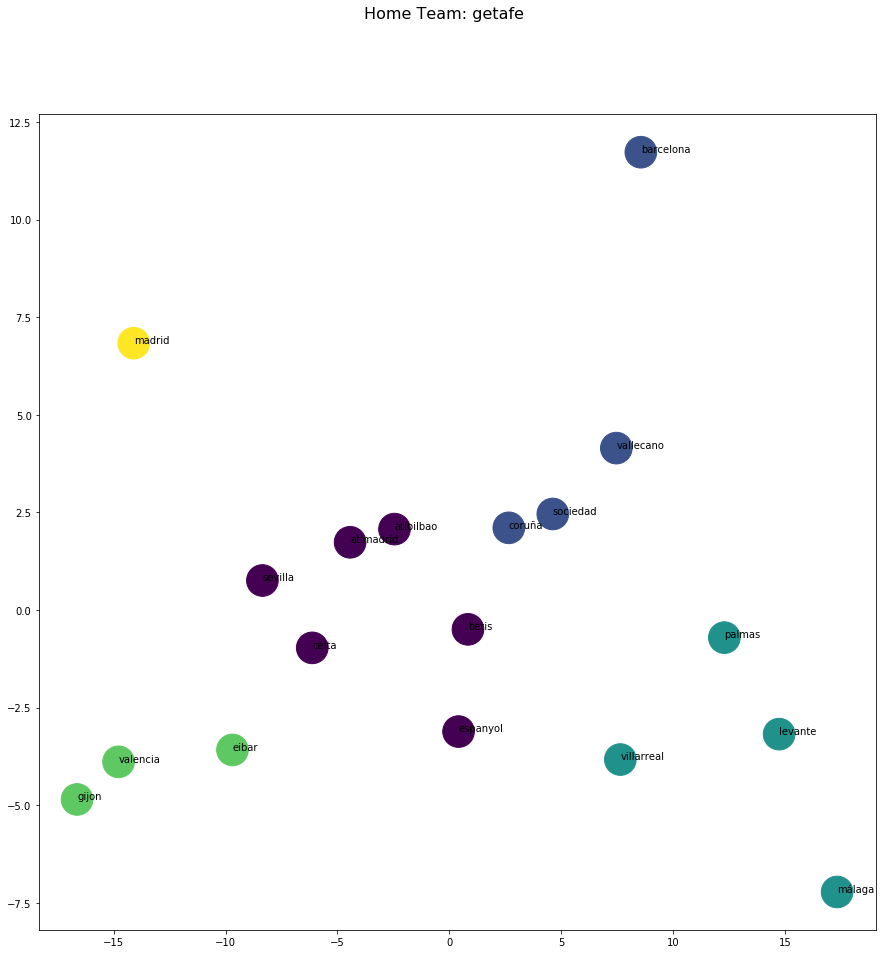

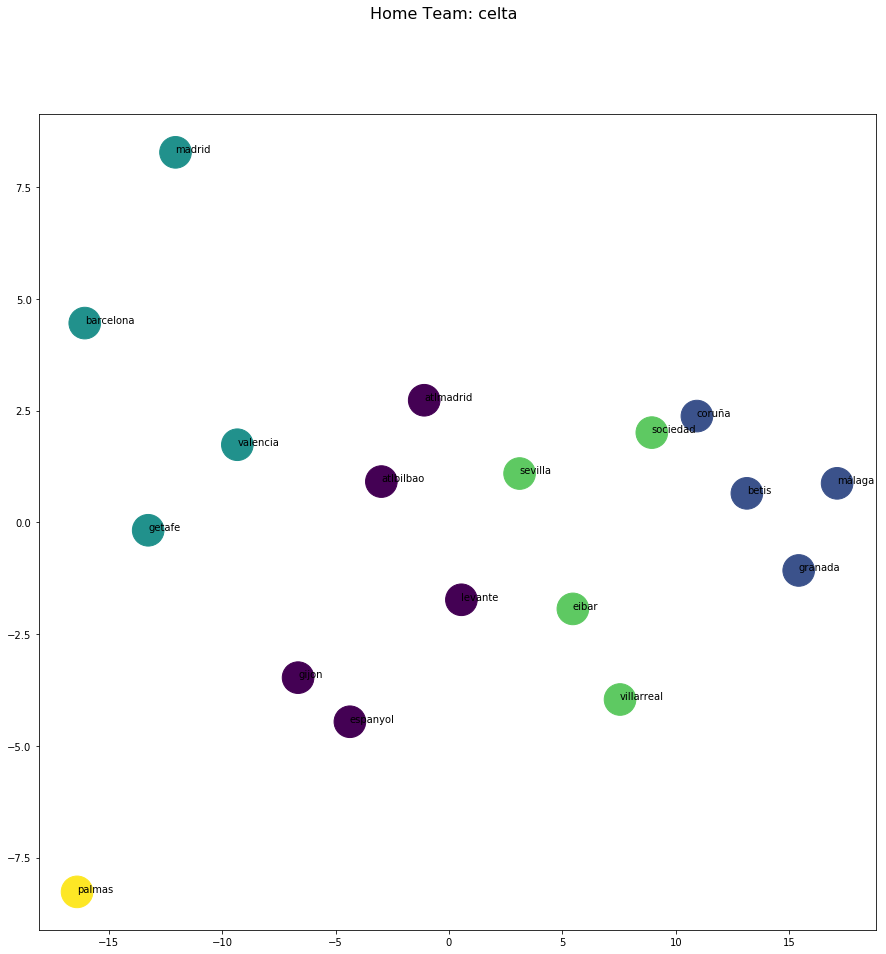

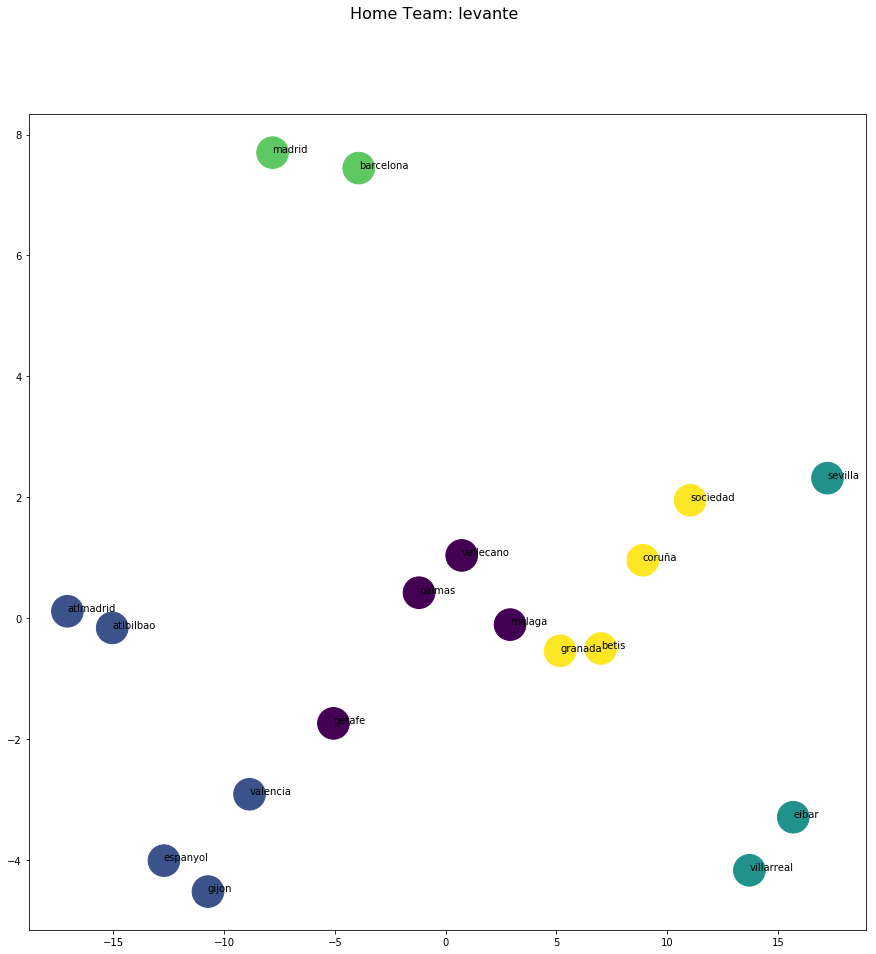

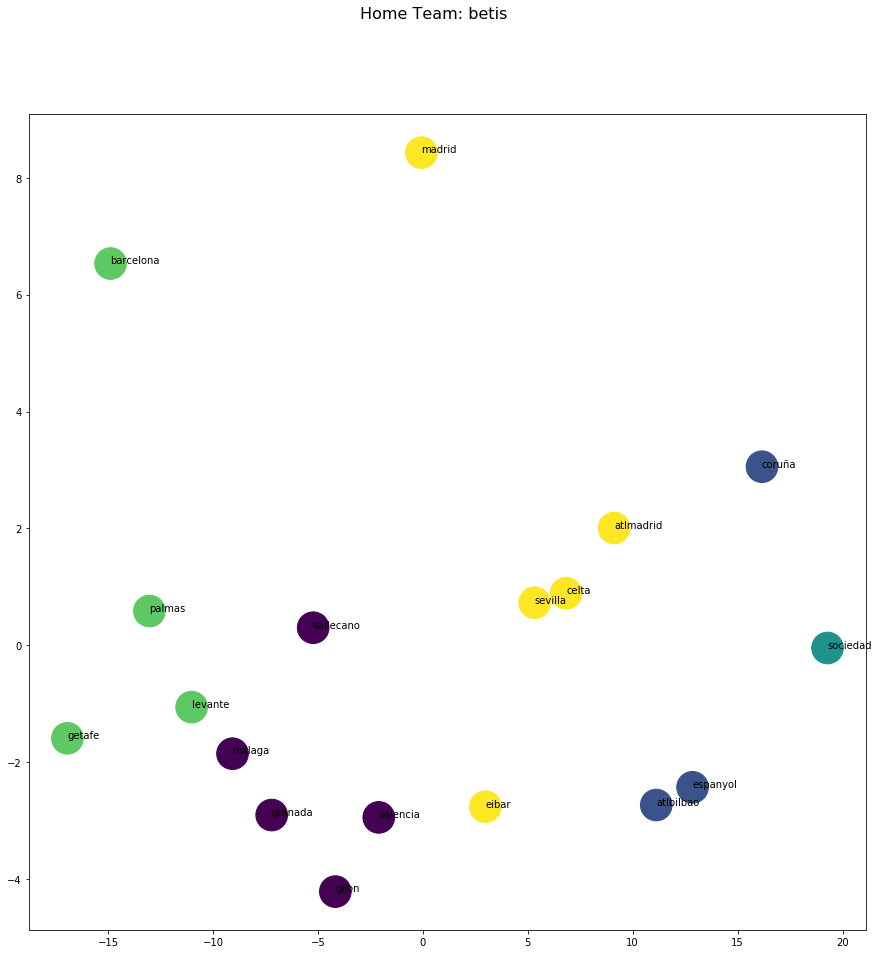

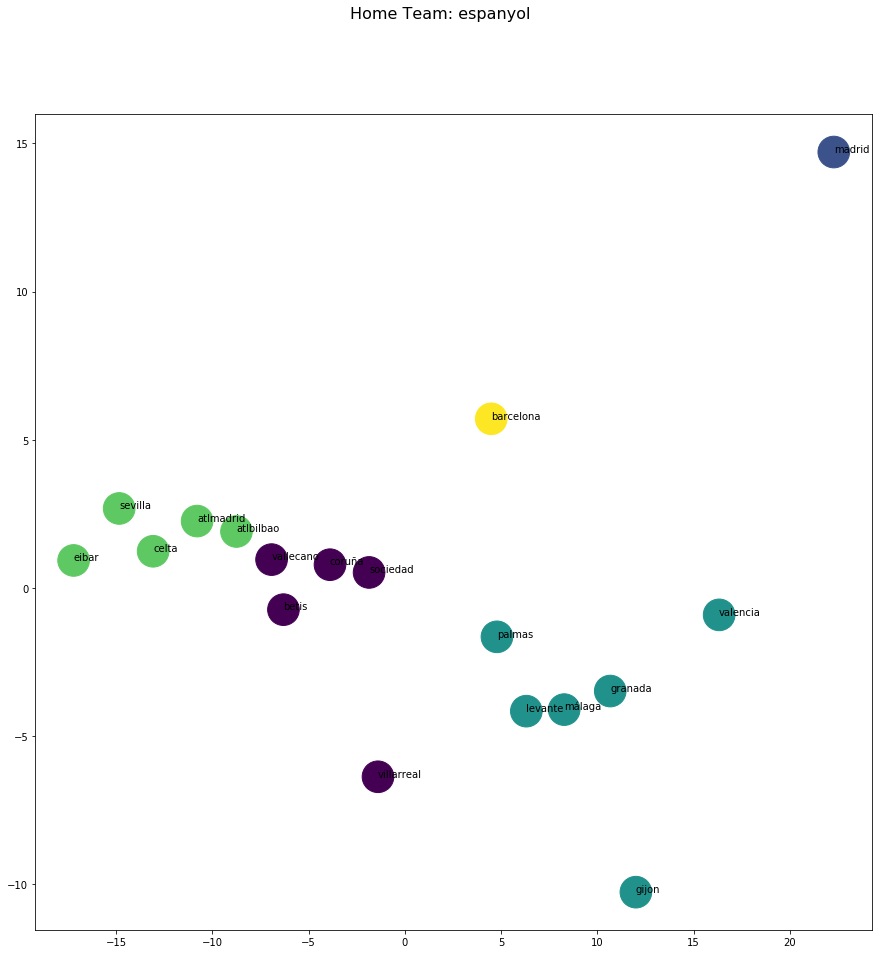

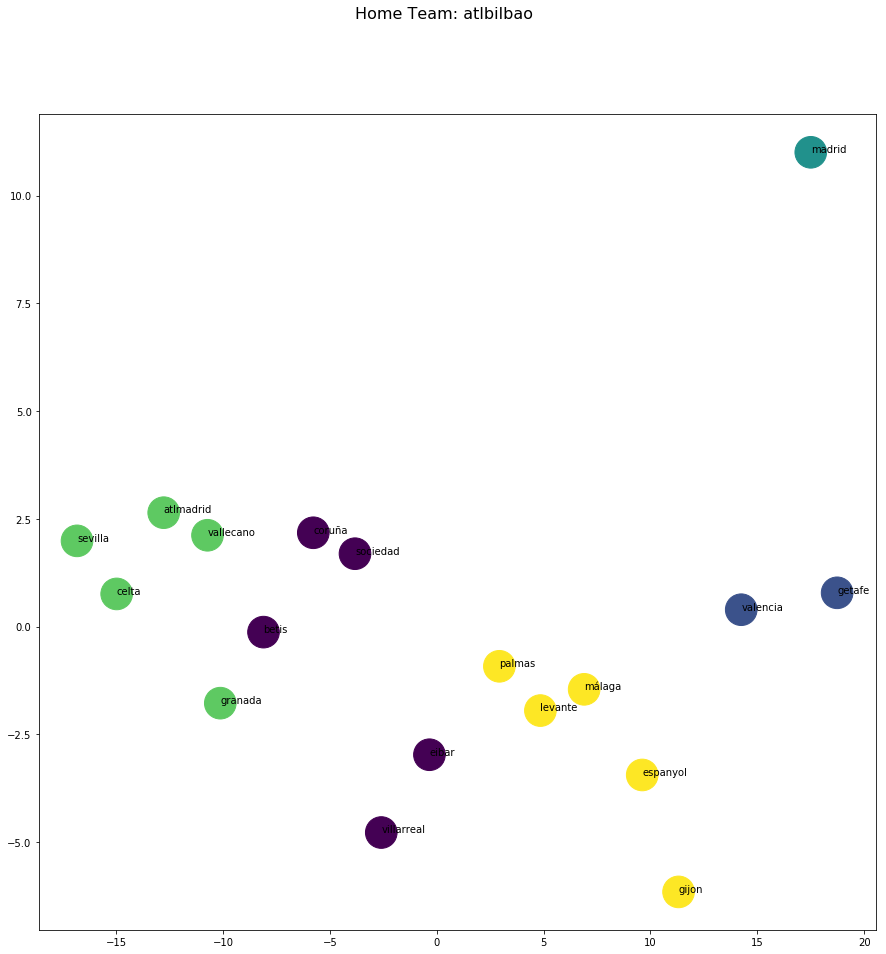

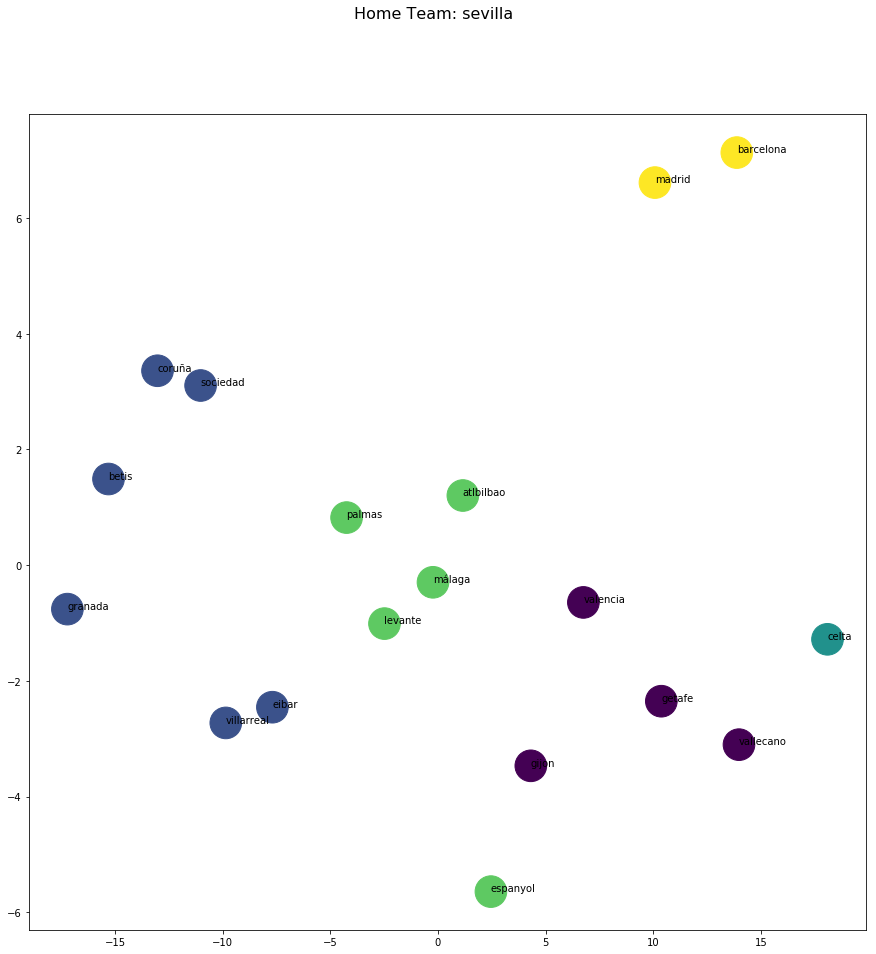

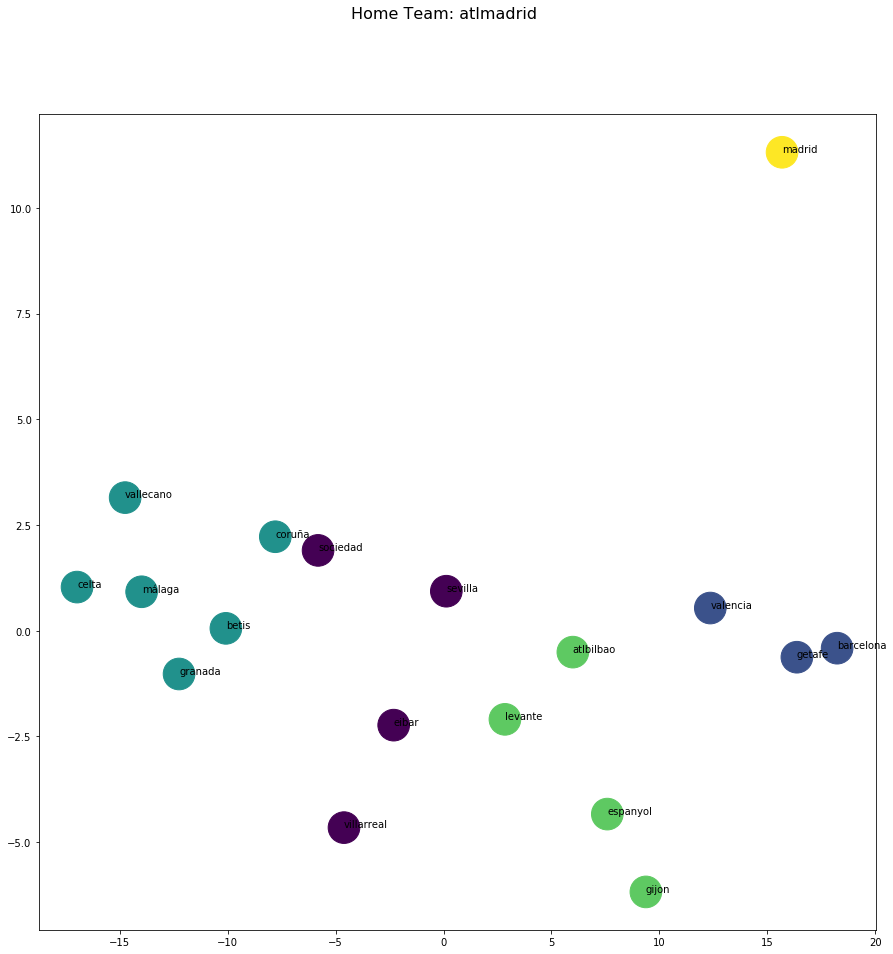

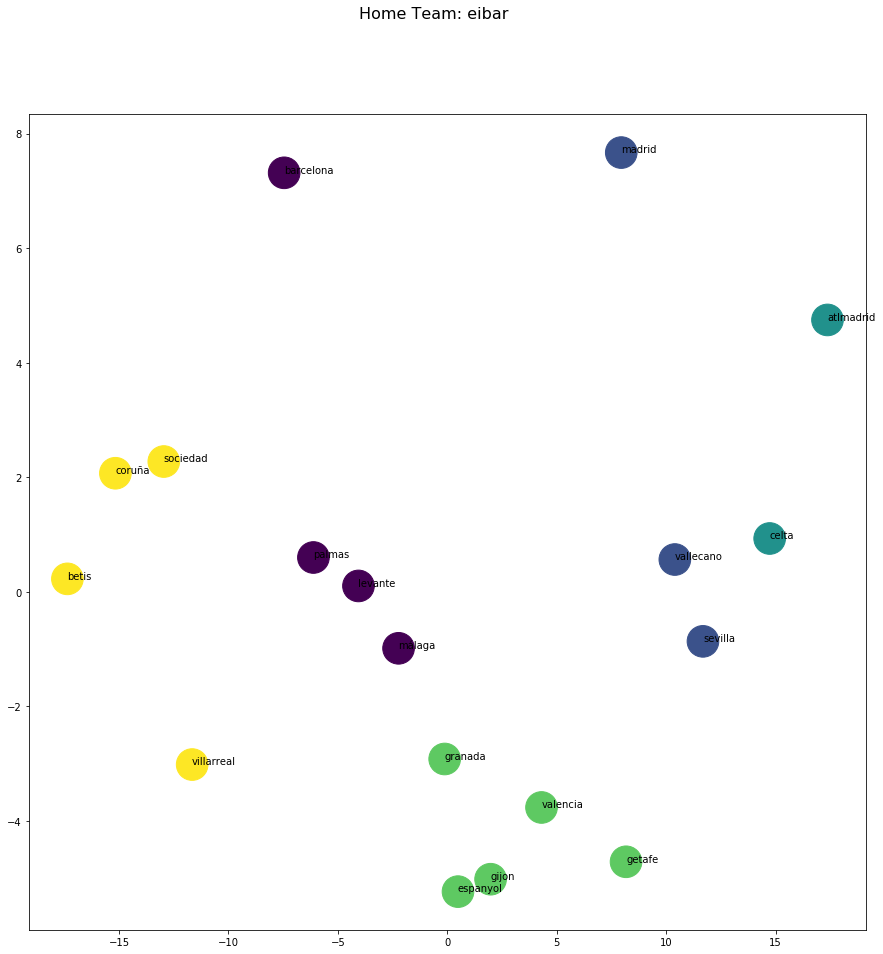

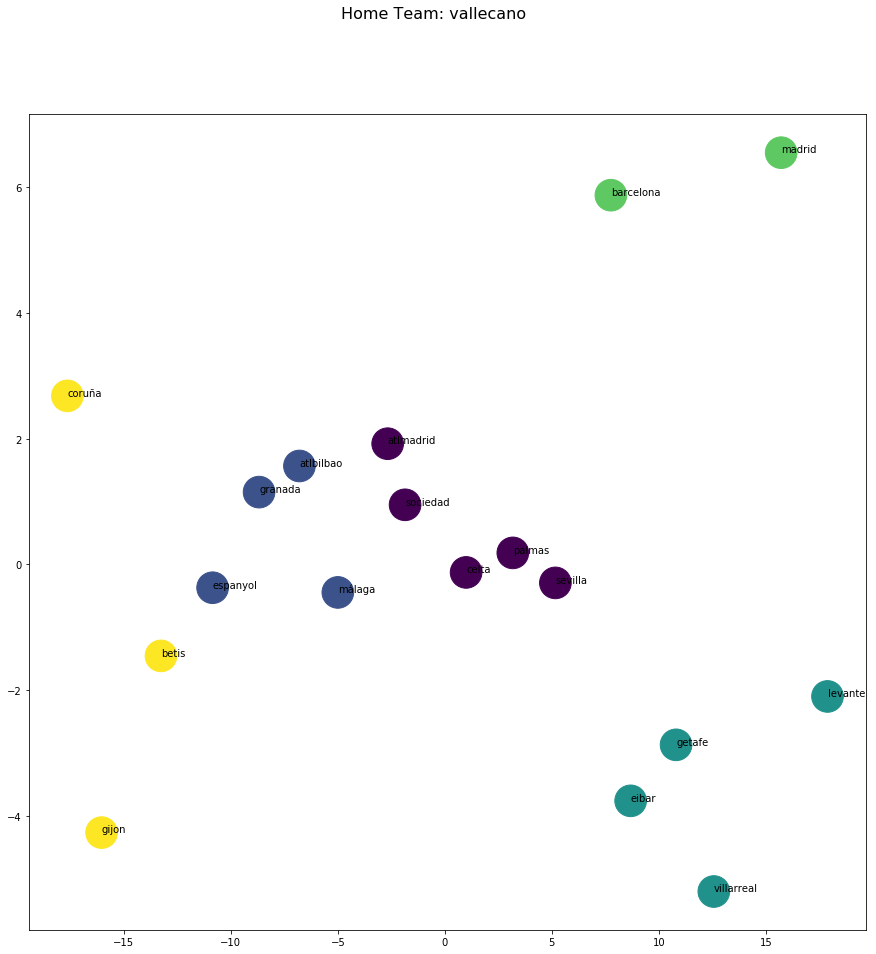

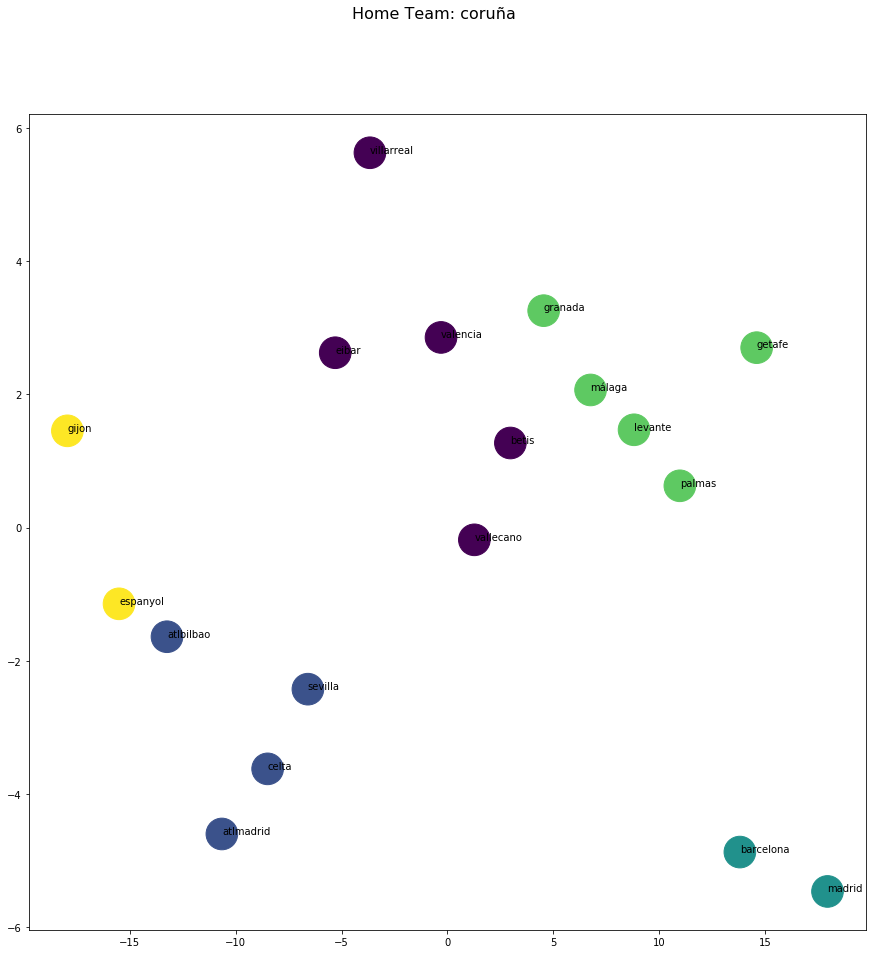

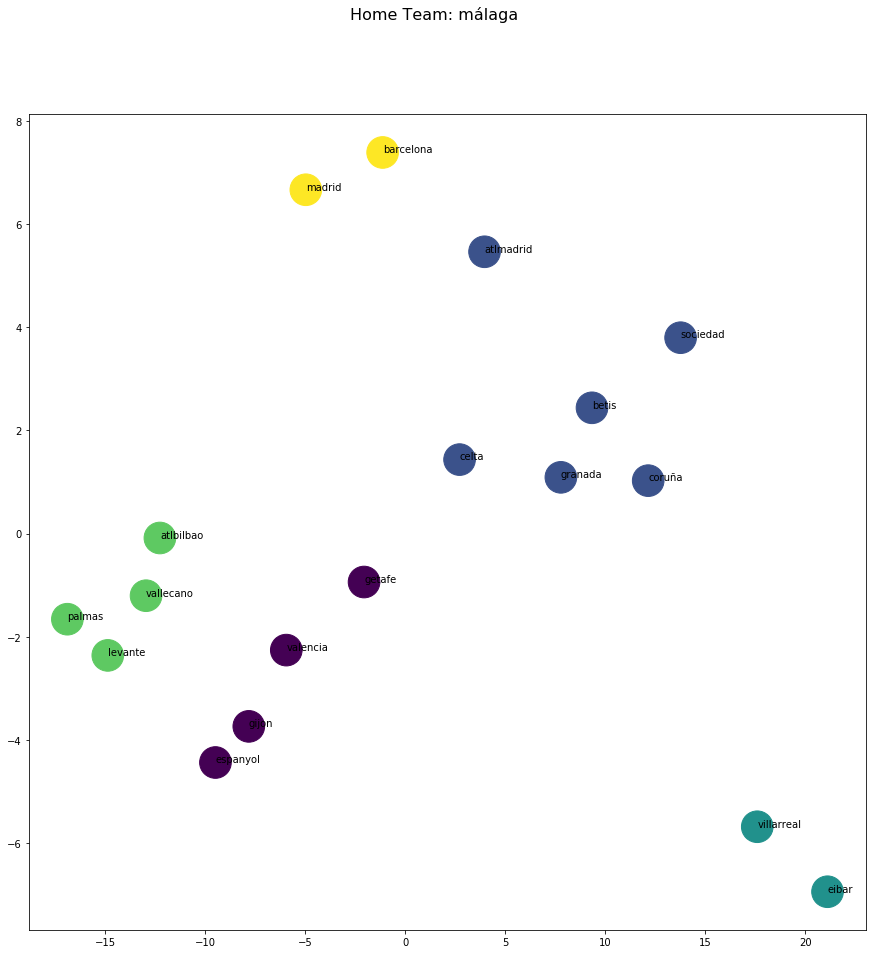

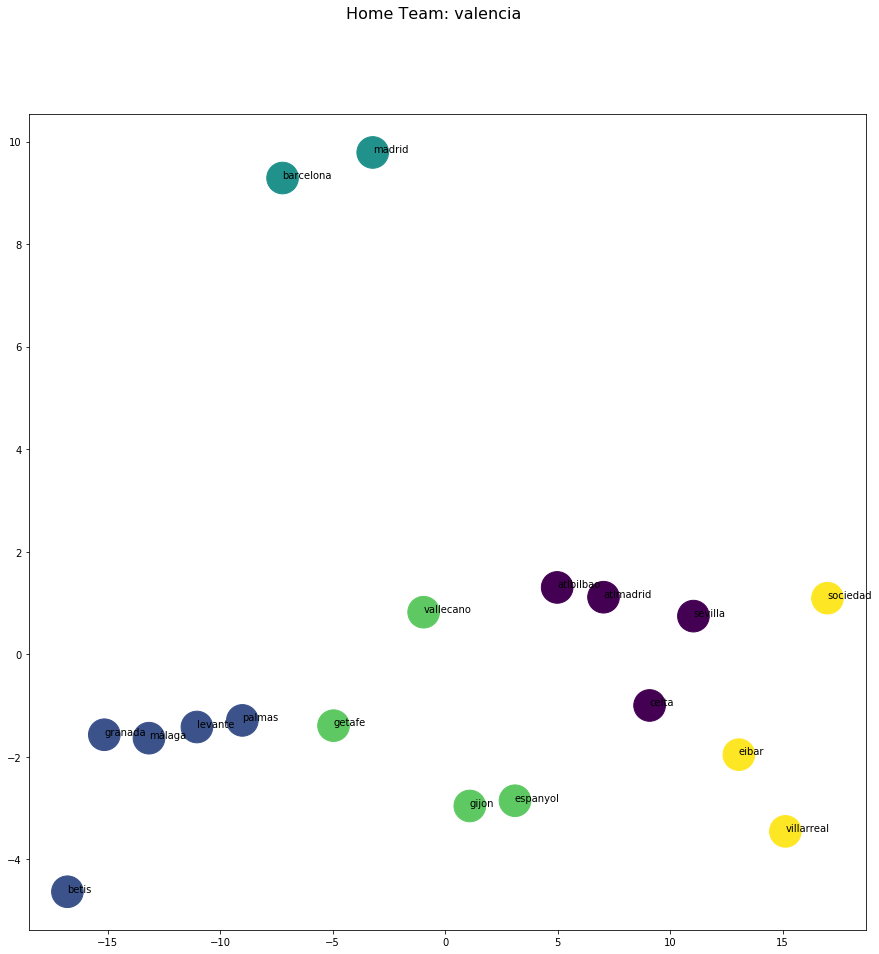

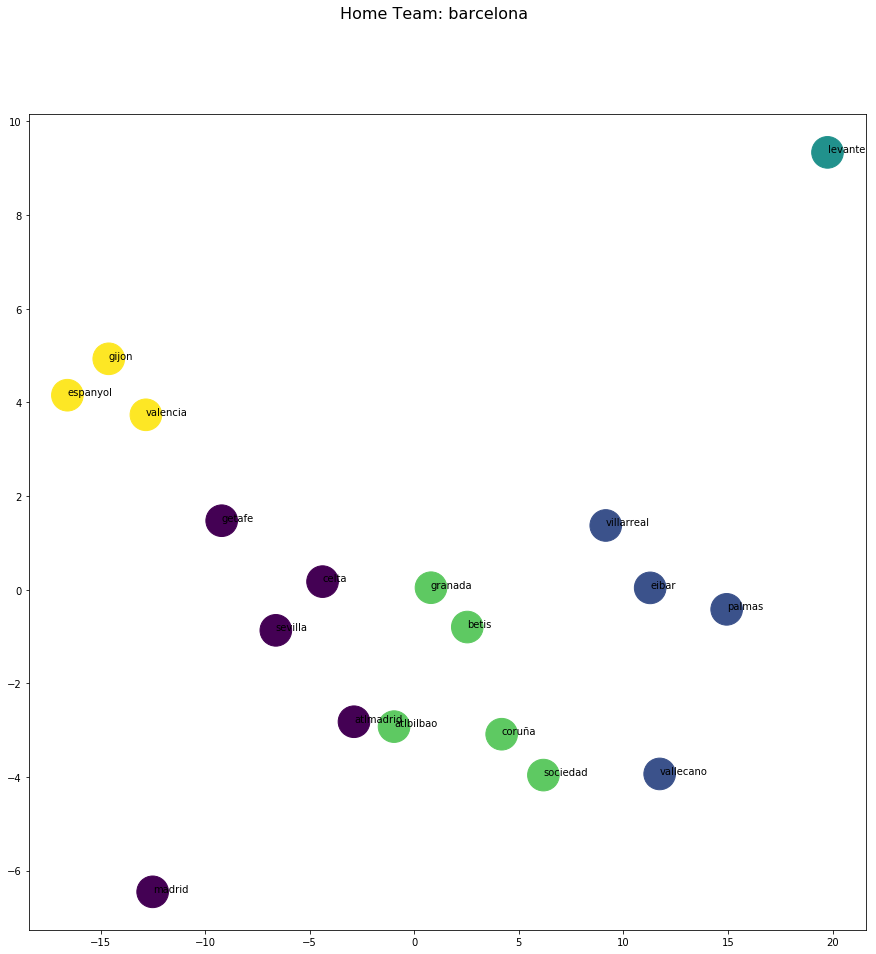

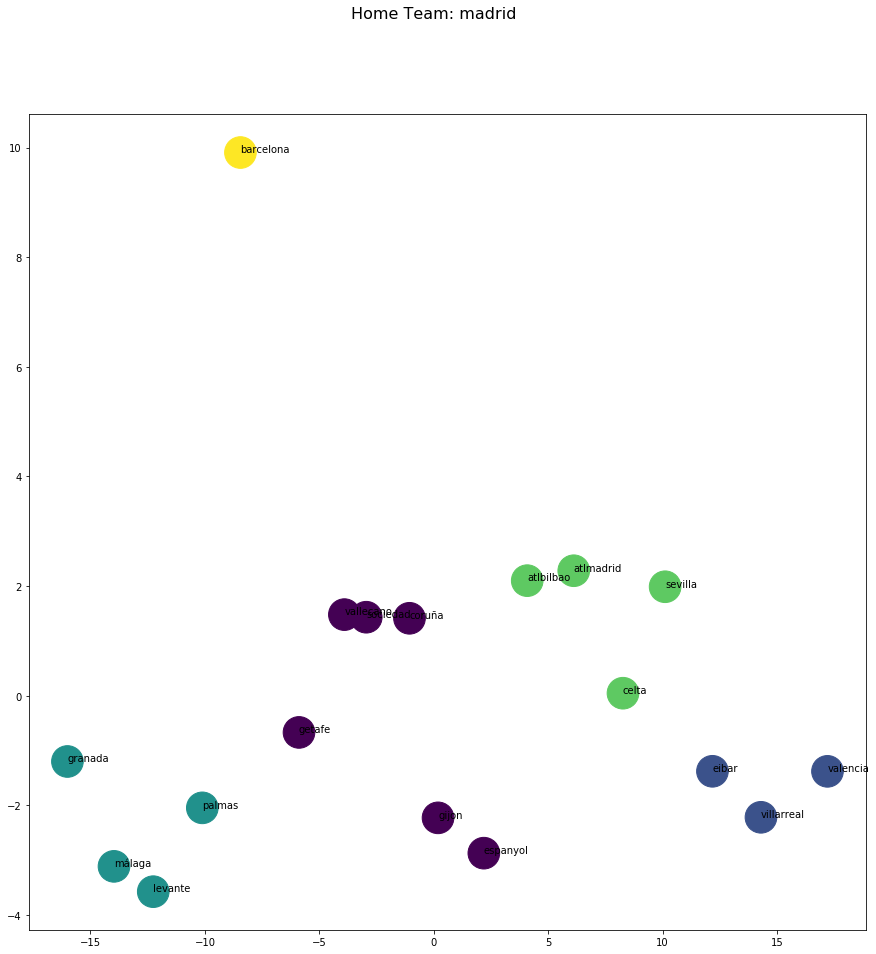

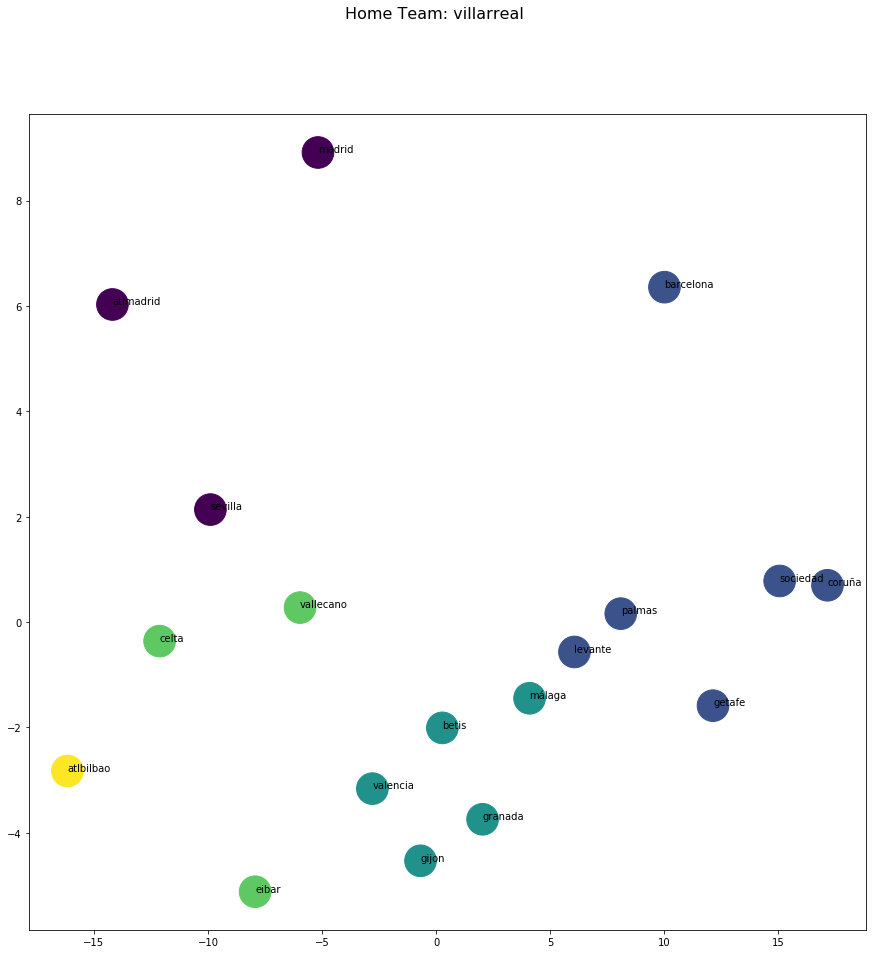

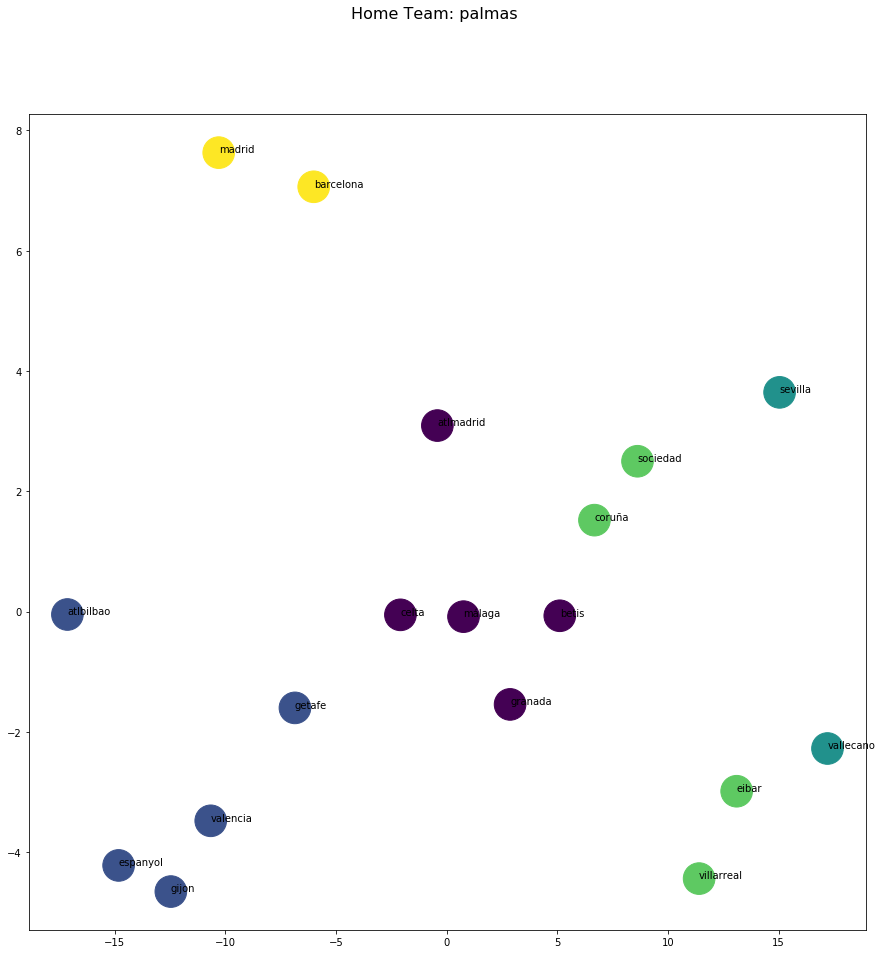

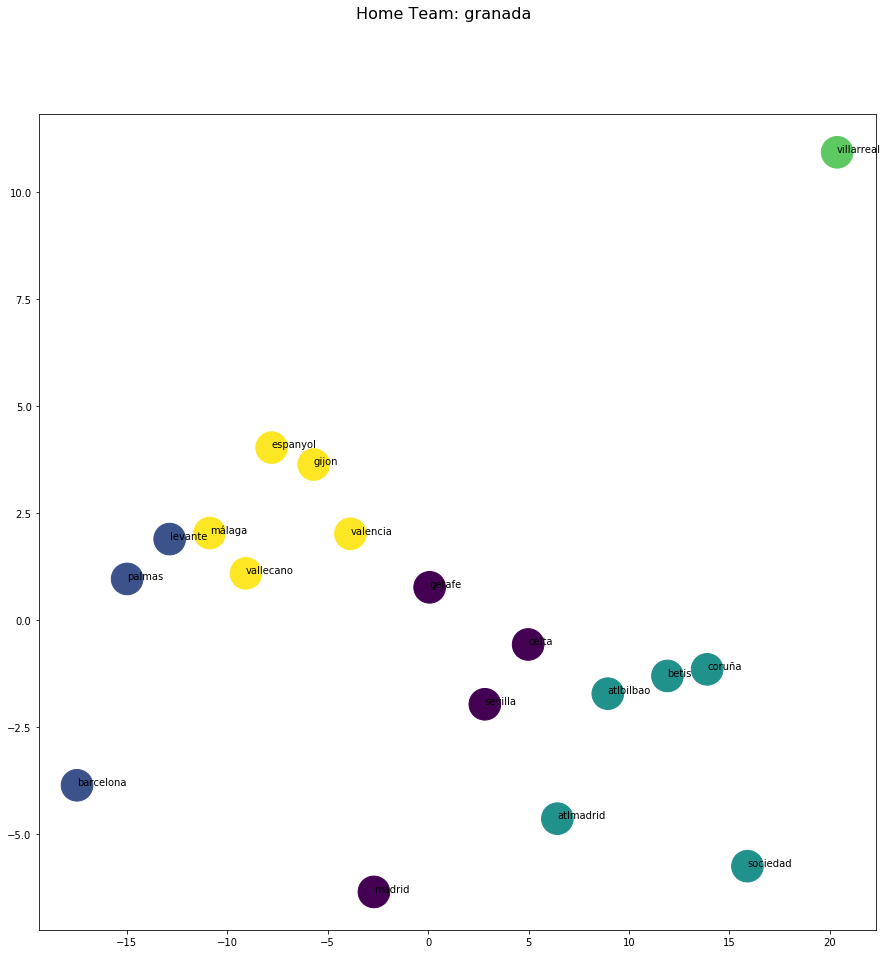

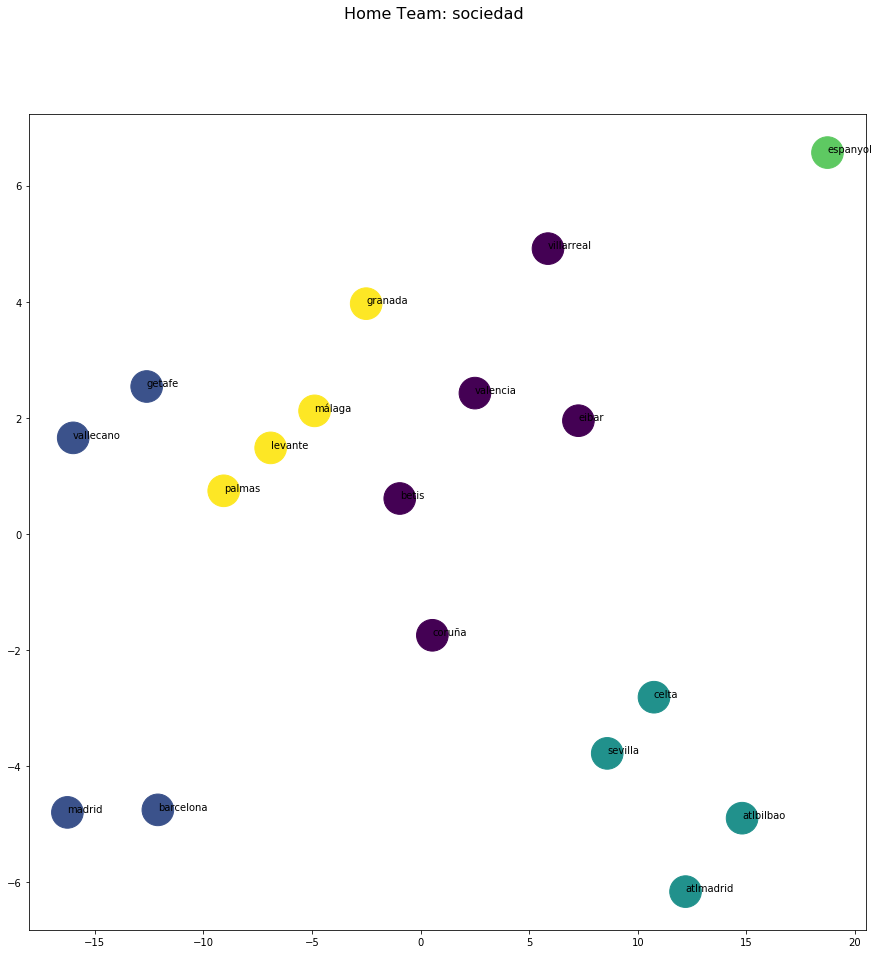

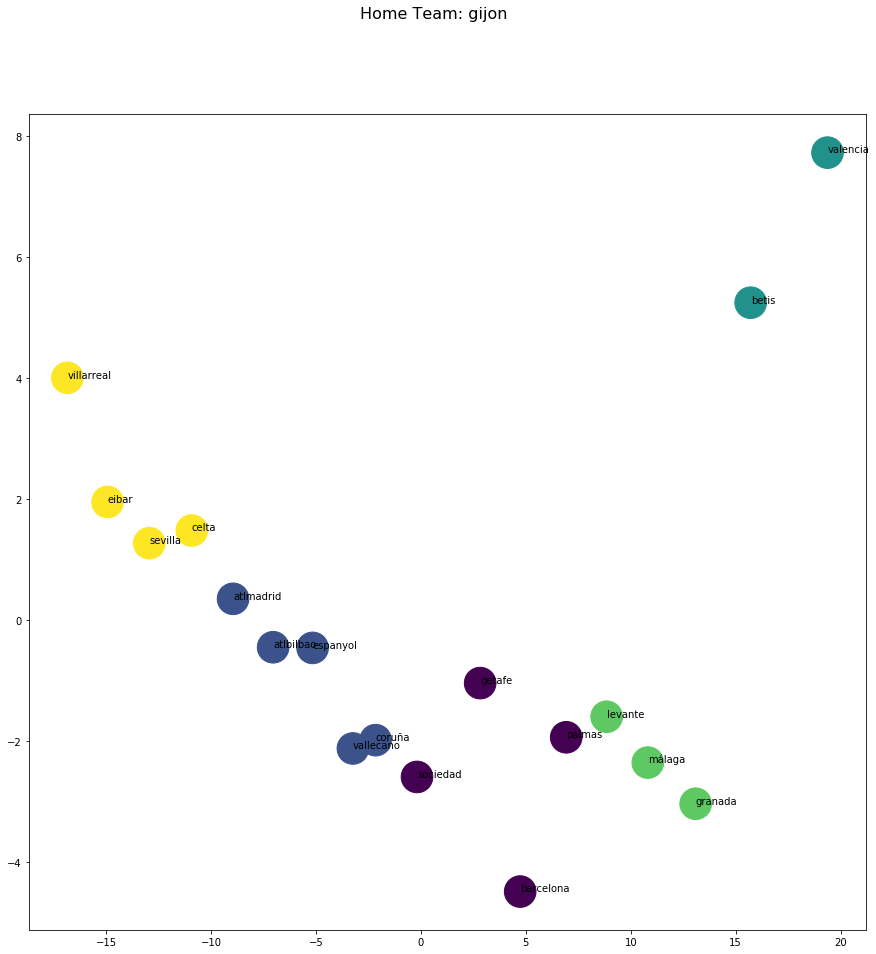

In [6]:
name_teams = set(df_clustering['home_team_name_id'])
for team in name_teams:
    df_clustering_teams =df_clustering.loc[df_clustering['home_team_name_id']== team,:]

    
    ## Remove Rows With Missing Values
    df_clustering_teams.dropna(inplace=True)

    #Remove labels
    away_teams =df_clustering_teams['away_team_name_id']
    df_clustering_teams = df_clustering_teams.drop(columns= ['labels','date','id','home_team_name_id','away_team_name_id'])

    
    df_clustering_teams= convert_to(df_clustering_teams,'onehot', all_categorical = True,columns ='None')
    
    kmeans = KMeans(n_clusters=5, random_state=111)
    kmeans.fit(df_clustering_teams)
    
    
    df_clust = pd.DataFrame(columns=['team_away','cluster_labels'])
    df_clust['team_away']= away_teams
    df_clust['cluster_labels']= kmeans.labels_

    pca = PCA(n_components=2).fit(df_clustering_teams)
    pca_2d = pca.transform(df_clustering_teams)

    fig, ax = plt.subplots(figsize=(15,15))
    fig.suptitle(f'Home Team: {team}', fontsize=16)
    ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, s=1000)

    for i, txt in enumerate(away_teams):
        ax.annotate(txt, (pca_2d[i, 0], pca_2d[i, 1]))

    

    for away_team in away_teams:
        df.loc[team,away_team] = df_clust.loc[df_clust['team_away']== away_team,'cluster_labels'].item()
df




In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, getafe to gijon
Data columns (total 20 columns):
getafe        18 non-null object
celta         18 non-null object
levante       18 non-null object
betis         18 non-null object
espanyol      18 non-null object
atlbilbao     18 non-null object
sevilla       18 non-null object
atlmadrid     18 non-null object
eibar         18 non-null object
vallecano     18 non-null object
coruña        18 non-null object
málaga        18 non-null object
valencia      18 non-null object
barcelona     18 non-null object
madrid        18 non-null object
villarreal    18 non-null object
palmas        18 non-null object
granada       18 non-null object
sociedad      18 non-null object
gijon         18 non-null object
dtypes: object(20)
memory usage: 3.9+ KB


In [10]:
df =df.fillna('1')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, getafe to gijon
Data columns (total 20 columns):
getafe        20 non-null object
celta         20 non-null object
levante       20 non-null object
betis         20 non-null object
espanyol      20 non-null object
atlbilbao     20 non-null object
sevilla       20 non-null object
atlmadrid     20 non-null object
eibar         20 non-null object
vallecano     20 non-null object
coruña        20 non-null object
málaga        20 non-null object
valencia      20 non-null object
barcelona     20 non-null object
madrid        20 non-null object
villarreal    20 non-null object
palmas        20 non-null object
granada       20 non-null object
sociedad      20 non-null object
gijon         20 non-null object
dtypes: object(20)
memory usage: 3.9+ KB


,getafe,celta,levante,betis,espanyol,atlbilbao,sevilla,atlmadrid,eibar,vallecano,coruña,málaga,valencia,barcelona,madrid,villarreal,palmas,granada,sociedad,gijon
getafe,1,0,2,0,0,0,0,0,3,1,1,2,3,1,4,2,2,1,1,3
celta,2,1,0,1,0,0,3,0,3,1,1,1,2,2,2,3,4,1,3,0
levante,0,1,1,4,1,1,2,1,2,0,4,0,1,3,3,2,0,4,4,1
betis,3,4,3,1,1,1,4,4,4,0,1,0,0,3,4,1,3,0,2,0
espanyol,1,3,2,0,1,3,3,3,3,0,0,2,2,4,1,0,2,2,0,2
atlbilbao,1,3,4,0,4,1,3,3,0,3,0,4,1,1,2,0,4,3,0,4
sevilla,0,2,3,1,3,3,1,1,1,0,1,3,0,4,4,1,3,1,1,0
atlmadrid,1,2,3,2,3,3,0,1,0,2,2,2,1,1,4,0,1,2,0,3
eibar,3,2,0,4,3,1,1,2,1,1,4,0,3,0,1,4,0,3,4,3
vallecano,2,0,2,4,1,1,0,0,2,1,4,1,1,3,3,2,0,1,0,4


In [11]:
dfT= df.T

In [12]:
dfT

,getafe,celta,levante,betis,espanyol,atlbilbao,sevilla,atlmadrid,eibar,vallecano,coruña,málaga,valencia,barcelona,madrid,villarreal,palmas,granada,sociedad,gijon
getafe,1,2,0,3,1,1,0,1,3,2,3,0,3,0,0,1,1,0,1,0
celta,0,1,1,4,3,3,2,2,2,0,1,1,0,0,3,3,0,0,2,4
levante,2,0,1,3,2,4,3,3,0,2,3,3,1,2,2,1,1,1,4,3
betis,0,1,4,1,0,0,1,2,4,4,0,1,1,3,1,2,0,2,0,2
espanyol,0,0,1,1,1,4,3,3,3,1,4,0,3,4,0,1,1,4,3,1
atlbilbao,0,0,1,1,3,1,3,3,1,1,1,3,0,3,3,4,1,2,2,1
sevilla,0,3,2,4,3,3,1,0,1,0,1,1,0,0,3,0,2,0,2,4
atlmadrid,0,0,1,4,3,3,1,1,2,0,1,1,0,0,3,0,0,2,2,1
eibar,3,3,2,4,3,0,1,0,1,2,0,2,4,1,1,3,3,1,0,4
vallecano,1,1,0,0,0,3,0,2,1,1,0,3,3,1,0,3,2,4,1,1


In [14]:
dfT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, getafe to gijon
Data columns (total 20 columns):
getafe        20 non-null object
celta         20 non-null object
levante       20 non-null object
betis         20 non-null object
espanyol      20 non-null object
atlbilbao     20 non-null object
sevilla       20 non-null object
atlmadrid     20 non-null object
eibar         20 non-null object
vallecano     20 non-null object
coruña        20 non-null object
málaga        20 non-null object
valencia      20 non-null object
barcelona     20 non-null object
madrid        20 non-null object
villarreal    20 non-null object
palmas        20 non-null object
granada       20 non-null object
sociedad      20 non-null object
gijon         20 non-null object
dtypes: object(20)
memory usage: 3.9+ KB


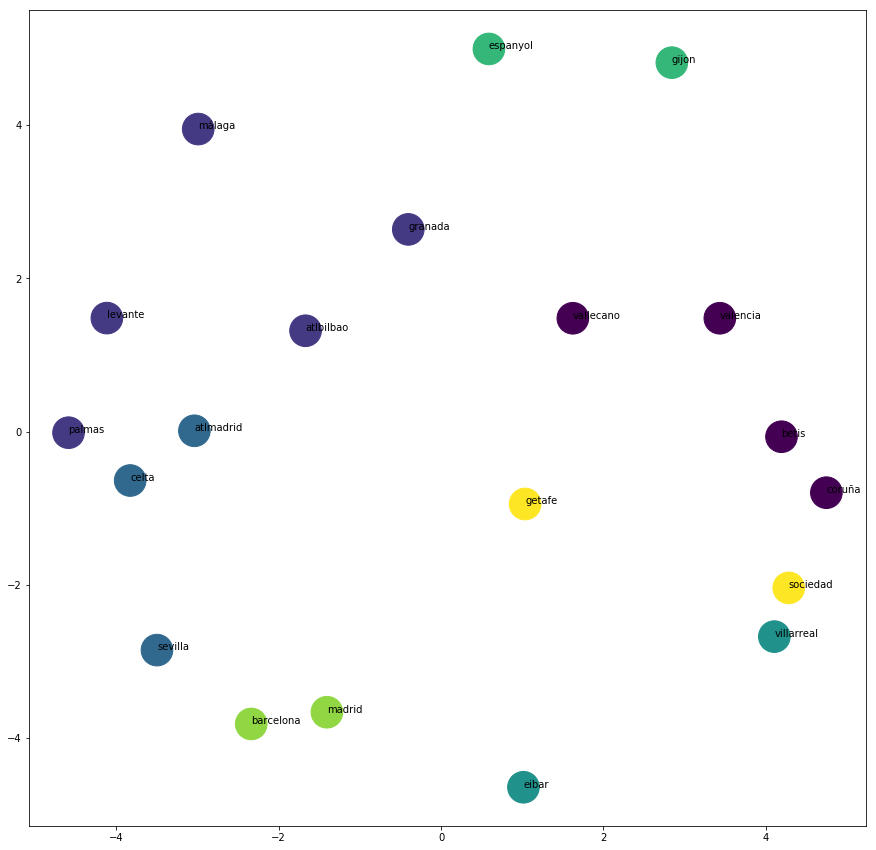

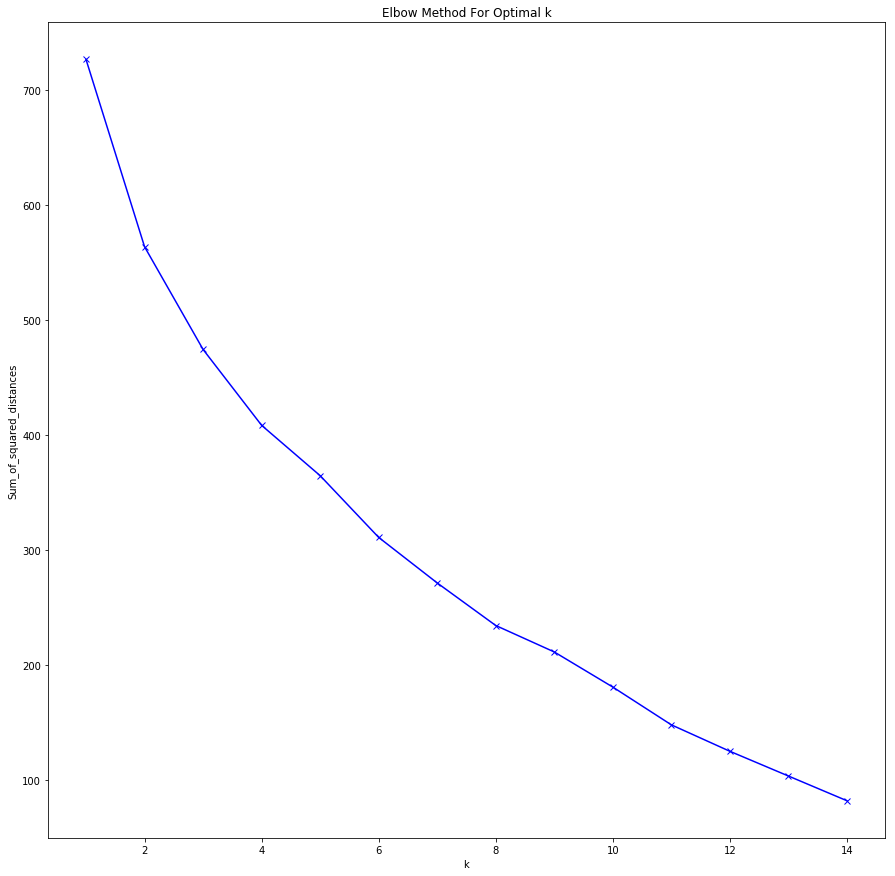

In [22]:
name_teams = set(dfT.index)


kmeans = KMeans(n_clusters=7, random_state=111)
kmeans.fit(dfT)
    
    


pca = PCA(n_components=2).fit(dfT)
pca_2d = pca.transform(dfT)

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, s=1000)

for i, txt in enumerate(name_teams):
    ax.annotate(txt, (pca_2d[i, 0], pca_2d[i, 1]))

    

#     for away_team in away_teams:
#         df.loc[team,away_team] = df_clust.loc[df_clust['team_away']== away_team,'cluster_labels'].item()


Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dfT)
    Sum_of_squared_distances.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(15,15))    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
df

In [ ]:
import skfuzzy as fuzz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(10, 10))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        df_clustering, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc), size=12)
    ax.axis('off')

fig1.tight_layout()

In [ ]:
!pip3 install -U scikit-fuzzy